# ADA 2018 - Homework 3



## Undestanding the StackOverflow community


Deadline: Nov 7th 2018, 23:59:59

Submission link: Check channel homework-3-public

TA Reviews

Grade for Textual Description: 5.75

Grade for Code Quality: 5.75

Grade for Results: 5.0

Comments: General comment : This is a good homework on the whole. Make sure to deeply understand what went wrong with the results by going through the solution.

Results : In task B2 a histogram would have been welcome instead of a simple line. In task C2 you missed that there are outliers on you graph. If you compute the pearson correlation factor without those leverage points then you get a really low score that shows there is actually  almost no correlation in the data. In taks D, I think what you did not manage to say in your analysis of the two bootstrap (mean and median) is that the mean is a less ROBUST statistic than the median and that's why we choose the median. 

Code quality : You plot too much query outputs and that makes your notebook messy. You could also make some computations more idiomatic by running them directly in spark (cf. solution).

Textual description : You would gain to make clearer and shorter what you want to say. We don't want you to write really long comments and analysis, just what is appropriate and relevant. Seek conciseness. 



StackOverflow is the most popular programming-related Q&A website. It serves as a platform for users to ask and answer questions and to vote questions and answers up or down. Users of StackOverflow can earn reputation points and "badges"; for example, a person is awarded 10 reputation points for receiving an "up" vote on an answer given to a question, and 5 points for the "up" vote on a question asked. Also, users receive badges for their valued contributions, which represents a kind of gamification of the traditional Q&A site. 

[Learn more about StackOverflow on Wikipedia](https://en.wikipedia.org/wiki/Stack_Overflow)

----

Dataset link:

https://drive.google.com/open?id=1POlGjqzw9v_pZ_bUnXGihOgk45kbvNjB

http://iccluster053.iccluster.epfl.ch/Posts.json.zip (mirror 1)

https://iloveadatas.com/datasets/Posts.json.zip (mirror 2)

Dataset description:

* **Id**: Id of the post
* **CreationDate**: Creation date of the post (String format)
* **PostTypeId**: Type of post (Question = 1, Answer = 2)
* **ParentId**: The id of the question. Only present if PostTypeId = 2
* **Score**: Points assigned by the users
* **Tags**: Tags of the question. Only present if PostTypeId = 1
* **Title**: Only present if PostTypeId = 1
* **ViewCount**: Only present if PostTypeId = 1

The dataset format is JSON. Here are examples of a question and an answer:

Question:
```json
{
    "Id": 10130734,
    "CreationDate": "2012-04-12T19:51:25.793+02:00",
    "PostTypeId": 1,
    "Score": 4,
    "Tags": "<python><pandas>",
    "Title": "Best way to insert a new value",
    "ViewCount": 3803
}
```

Answer:
```json
{  
   "CreationDate":"2010-10-26T03:19:05.063+02:00",
   "Id":4020440,
   "ParentId":4020214,
   "PostTypeId":2,
   "Score":1
}
```

----
Useful resources:

**Spark SQL, DataFrames and Datasets Guide**

https://spark.apache.org/docs/latest/sql-programming-guide.html

**Database schema documentation for the public data dump**

https://meta.stackexchange.com/questions/2677/database-schema-documentation-for-the-public-data-dump-and-sede

----

**Note:** Use Spark where possible. Some computations can take more than 10 minutes on a common notebook. Consider to save partial results on disk.

In [1]:
# Add your imports here
import pandas as pd
import numpy as np
import scipy as sp
from pyspark.sql.functions import *
from pyspark.sql import *
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.ticker
from pyspark.sql.types import FloatType
import pyspark.sql.functions as func
import seaborn as sns
sns.set(style='darkgrid')
pd.set_option('float_format', '{:,.0f}'.format)
spark = SparkSession.builder.getOrCreate()

### Task A: Convert the dataset to a more convenient format
As a warm-up task (and to avoid to warm up your laptop too much), load the dataset into a Spark dataframe, show the content, and save it in the _Parquet_ format. Use this step to convert the fields to a more convenient form.

Answer the following questions:

1. How many questions have been asked on StackOverflow?
2. How many answers have been given?
3. What is the percentage of questions with a score of 0?

**Hint:** The next tasks involve a time difference. Consider storing time in numeric format.

We load the dataset into a Spark dataframe `Stack_Overflow` and show the content.

**ATTENTION**

Please unzip the Posts.json.zip at first. 

In [2]:
# Load the dataset into a Spark dataframe
Stack_Overflow = spark.read.json("Posts.json")

In [3]:
Stack_Overflow.show()

+--------------------+-------+--------+----------+-----+--------------------+--------------------+---------+
|        CreationDate|     Id|ParentId|PostTypeId|Score|                Tags|               Title|ViewCount|
+--------------------+-------+--------+----------+-----+--------------------+--------------------+---------+
|2010-10-26T03:17:...|4020437|    null|         1|    0|<asp.net-mvc><jqu...|display jquery di...|      510|
|2010-10-26T03:18:...|4020438|    null|         1|    0|<javascript><html...|Why can only my m...|       62|
|2010-10-26T03:19:...|4020440| 4020214|         2|    1|                null|                null|     null|
|2010-10-26T03:19:...|4020441| 3938154|         2|    0|                null|                null|     null|
|2010-10-26T03:20:...|4020443| 4020419|         2|  324|                null|                null|     null|
|2010-10-26T03:20:...|4020444| 4020433|         2|    0|                null|                null|     null|
|2010-10-26T03:21:.

Next, we check the schema of Stack_Overflow dataframe to see the data types for each column. We can notice that `CreationDate` is a string with formal timestap format. Therefore, we use the hint and change this column to type `timestamp` which we will use for next tasks.

In [4]:
Stack_Overflow

DataFrame[CreationDate: string, Id: bigint, ParentId: bigint, PostTypeId: bigint, Score: bigint, Tags: string, Title: string, ViewCount: bigint]

In [5]:
# Set standard time zone as UTC and caculate the relative timestamp   
spark.conf.set("spark.sql.session.timeZone", "UTC")
Stack_Overflow = Stack_Overflow.withColumn('CreationDate', to_utc_timestamp("CreationDate", "y-MM-dd'T'hh:mm:ssZ"))

In [6]:
Stack_Overflow.show()

+--------------------+-------+--------+----------+-----+--------------------+--------------------+---------+
|        CreationDate|     Id|ParentId|PostTypeId|Score|                Tags|               Title|ViewCount|
+--------------------+-------+--------+----------+-----+--------------------+--------------------+---------+
|2010-10-26 01:17:...|4020437|    null|         1|    0|<asp.net-mvc><jqu...|display jquery di...|      510|
|2010-10-26 01:18:...|4020438|    null|         1|    0|<javascript><html...|Why can only my m...|       62|
|2010-10-26 01:19:...|4020440| 4020214|         2|    1|                null|                null|     null|
|2010-10-26 01:19:...|4020441| 3938154|         2|    0|                null|                null|     null|
|2010-10-26 01:20:...|4020443| 4020419|         2|  324|                null|                null|     null|
|2010-10-26 01:20:...|4020444| 4020433|         2|    0|                null|                null|     null|
|2010-10-26 01:21:.

In [6]:
# Save the data in Parquet format to get faster access
Stack_Overflow.write.mode('overwrite').parquet("stack.parquet")

In [2]:
parquet_stack = spark.read.parquet("stack.parquet")
parquet_stack

DataFrame[CreationDate: timestamp, Id: bigint, ParentId: bigint, PostTypeId: bigint, Score: bigint, Tags: string, Title: string, ViewCount: bigint]

And now we can see that the `CreationDate` is converted to timestamp type. Next we create two different dataframes for questions and answers, so we can answer the questions:


__Question 1: How many questions have been asked on StackOverflow?__

In [3]:
# Select the questions from the dataframe
question = parquet_stack.filter((parquet_stack['PostTypeId']==1) & (parquet_stack['Tags']!='null'))
print('The total number of questions is: {:,}.'.format(question.count()))

The total number of questions is: 15,647,060.


__Question 2: How many answers have been given?__

In [4]:
# Select the answers from the dataframe
answer = parquet_stack.filter(parquet_stack['PostTypeId']==2)
print('The total number of answers is: {:,}.'.format(answer.count()))

The total number of answers is: 25,192,772.


__Question 3: What is the percentage of questions with a score of 0?__

In [5]:
# Caculate the percentage of questions with a score of 0
question_0score = question.filter(parquet_stack[4]=="0")
print('The percentage of questions with a score of 0 is: {0:.2f} %.'.format(question_0score.count()/question.count()*100))

The percentage of questions with a score of 0 is: 46.54 %.


### Task B: What are the 10 most popular tags?

What are the most popular tags in StackOverflow? Use Spark to extract the information you need, and answer the following questions with Pandas and Matplotlib (or Seaborn):

1. What is the proportion of tags that appear in fewer than 100 questions?
2. Plot the distribution of the tag counts using an appropriate representation.
3. Plot a bar chart with the number of questions for the 10 most popular tags.

For each task describe your findings briefly.

__Question 1:__

In order to get the proportion of tags having particular frequency, first we need to separate all different tags and then count the number of times they appear in the dataframe. Then, we apply threshold of 100 and show the answer.

In [6]:
# Get the tag dataframe
df_tag = question.select("Tags")
df_tag.show(5, truncate=False)

+-------------------------------------------------------------------------+
|Tags                                                                     |
+-------------------------------------------------------------------------+
|<flash><react-native>                                                    |
|<postgresql><formatting><plpgsql>                                        |
|<python><websocket><python-asyncio>                                      |
|<facebook><facebook-javascript-sdk><share><facebook-opengraph><opengraph>|
|<mongodb><shell>                                                         |
+-------------------------------------------------------------------------+
only showing top 5 rows



Since df_tag is a Spark dataframe, we convert the dataframe to RDD and use flatMap and map funtions to separate each tag and make a list for them. We first split tags in each row with "><" to have tag list like `<flash`, `python`, `facebook>`. Then, we use map with replace function to delete ">" and "<" at the beginning and ending.

In [7]:
# Split tags in each row with "><" and delete the ">" and "<" in the beginning and ending
tags = df_tag.rdd.flatMap(lambda r: r[0].strip('<').strip('>').split('><'))
tags.take(5)

['flash', 'react-native', 'postgresql', 'formatting', 'plpgsql']

Now, we just count the number of each tag and sort them by the number they appear in a new pandas dataframe (which we need to plot the data in the next questions).

In [8]:
# Count the number of each tag and sort them by the number they appear in a new pandas dataframe
pd_tag = pd.DataFrame(tags.map(lambda a: (a,1)).reduceByKey(lambda a,b: a+b)\
                    .sortBy(lambda r: r[1], ascending = False).collect(), columns = ['Tag','Count'])
pd_tag.head()

,Tag,Count
0,javascript,1585495
1,java,1352735
2,c#,1172492
3,php,1136082
4,android,1088811


In [9]:
print('The total number of different tags is: {:,}.'.format(pd_tag['Tag'].count()))

The total number of different tags is: 52,994.


__So the proportion of tags that appear in fewer than 100 questions should be:__

In [10]:
print('The  proportion of tags that appear in fewer than 100 questions is: {0:.2f} %.'\
      .format(pd_tag[pd_tag['Count']<100]['Count'].count()/pd_tag['Count'].count()*100))

The  proportion of tags that appear in fewer than 100 questions is: 67.98 %.


__Question 2:   Plot the distribution of the tag counts using an appropriate representation.__

Text(0.5, 1.0, 'Distribution of tag counts')

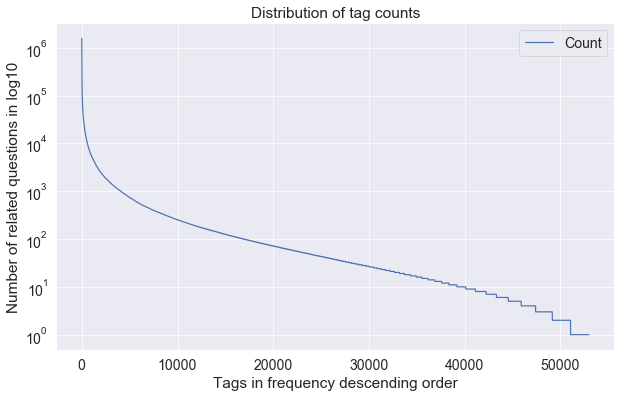

In [11]:
sns.set_context("paper", font_scale=1.6)
fig1 = pd_tag.plot(logy=True, figsize=(10,6))
fig1.set_xlabel('Tags in frequency descending order')
fig1.set_ylabel('Number of related questions in log10')
fig1.set_title('Distribution of tag counts')

   In this plot, we use `logy` for better representation of the data because we find that small proportion of Tag values have so high variance that the plot cannot show them properly (The left part where tags have high frequency). So we activate the ylog to shorten the y-axis scale.
   
   However, the normal plot still cannot perfectly show the outliers, median, mean etc. We want to show more information on the plot to represent the dataset more thoroughly, so we choose boxplot to show the distribution of tags.

Text(0.5, 1.0, 'Distribution of tag counts')

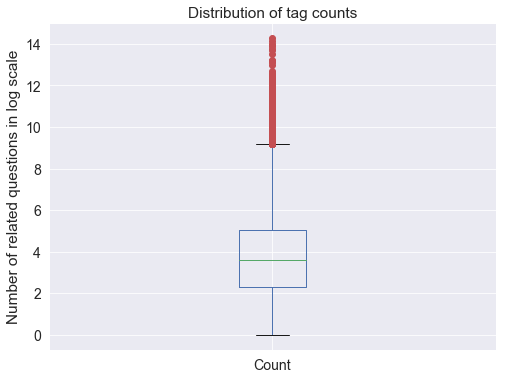

In [12]:
# Draw boxplot
fig2 = np.log(pd_tag.Count).plot.box(sym='r', figsize=(8,6))
fig2.set_ylabel('Number of related questions in log scale')
fig2.set_title('Distribution of tag counts')

__Question 3:__

In oder to plot a bar chart with the number of questions for the 10 most popular tags, we have to extract the 10 most popular tags. Since we have already made a descending tags dataframe: `pd_tag`,we just take the first 10 rows of data and plot the results.

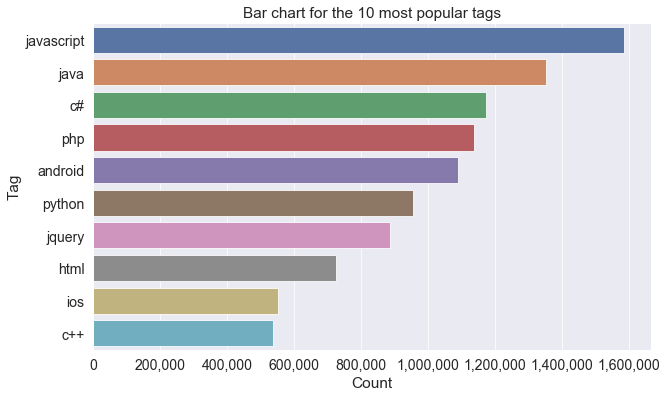

In [13]:
sns.set_context("paper", font_scale=1.6)
top_tag = pd_tag.head(10)
fig3 = plt.figure(figsize=(10,6))
fig3 = sns.barplot(top_tag.Count, top_tag.Tag)
fig3.set_title('Bar chart for the 10 most popular tags')
fig3.get_xaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

### Task C: View-score relation

We want to investigate the correlation between the view count and the score of questions.

1. Get the view count and score of the questions with tag ```random-effects``` and visualize the relation between these two variables using an appropriate plot.
2. Are these two variables correlated? Use the Pearson coefficient to validate your hypothesis. Discuss your findings in detail.

**Hint:** Inspect the data visually before drawing your conclusions.

__Question1:__

For getting questions with `random-effects` tags, we have two ways:
1. use sql with  `SELECT * FROM question WHERE Tags LIKE "%<random-effects>%"`
2. use Column.contains() to get a boolean filter and apply it to question dataframe

To be more brief, we implement with the 2nd solution below:

In [14]:
# Get questions with random-effects tags and convert to pandas
random_effects = question[question.Tags.contains('<random-effects>')].toPandas()
random_effects.head()

,CreationDate,Id,ParentId,PostTypeId,Score,Tags,Title,ViewCount
0,2018-03-20 11:48:15.283,49383437,None,1,0,<statistics><regression><multi-level><random-e...,Estimation sample used in random effects multi...,12
1,2018-03-13 04:01:55.350,49248152,None,1,0,<r><plm><random-effects>,"R - plm package error - ""system is exactly sin...",495
2,2018-03-14 09:10:08.173,49277430,None,1,0,<r><nlme><random-effects>,Covariance structure in lme - AR(1),220
3,2017-10-02 13:02:29.983,46526027,None,1,0,<random-effects>,GLMM model design,21
4,2018-08-03 20:29:11.630,51679728,None,1,5,<r><nlme><random-effects>,`nlme` with crossed random effects,126


Here we create a Jointplot to show the relation between view count and score of the questions with tag random-effects, as well as their distributions. SInce we have a few data points for ViewCount which are larger than the other, we use log-scaling to show the results.

/anaconda3/envs/ada/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


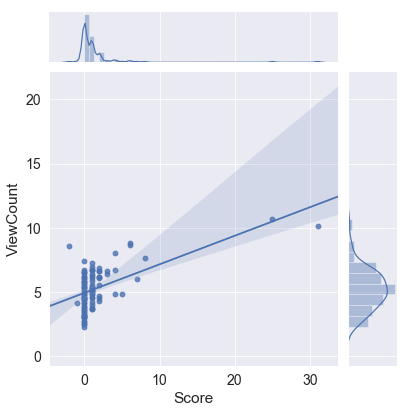

In [15]:
sns.jointplot(random_effects['Score'], np.log(random_effects['ViewCount']), kind='reg', stat_func=None)

__Question2:__

We find the Pearson coefficient and the correlation between the score and viewcount data points. Then we present a boxplot from where we can observe the correlation closely.

In [16]:
# Find the correlation of Score and ViewCount using Pearson coefficient
print('The correlation of score and viewcount is: {:,}.'.format(random_effects['Score'].corr(random_effects['ViewCount'],method = 'pearson')))


The correlation of score and viewcount is: 0.8821972419941507.


Text(0.5, 1.0, 'Boxplot grouped by Score')

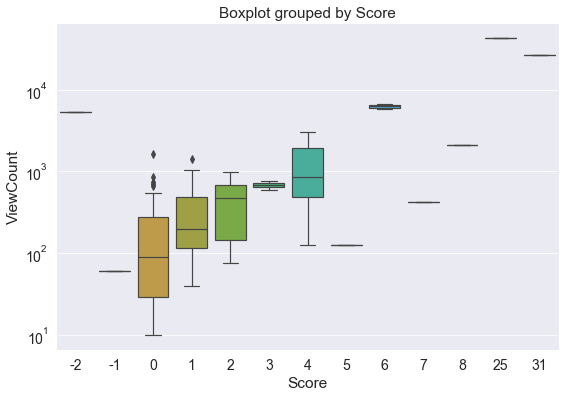

In [17]:
fig5, ax = plt.subplots(figsize=(9, 6))
ax.set_yscale('log')
sns.boxplot(random_effects['Score'], random_effects['ViewCount'])
ax.set_title('Boxplot grouped by Score')

From the correlation, these two variables get 0.88 as Pearson's correlation, which is high enough to indicate this two factors are linear correlated. And from the box plot above, we can notice that when we increase the score, median and quartile of log ViewCount become larger overall. In other words, the higher the score a question has, the more possibility to get large view count, which complies with reality.

### Task D: What are the tags with the fastest first answer?

What are the tags that have the fastest response time from the community? We define the response time as the difference in seconds between the timestamps of the question and of the first answer received.

1. Get the response time for the first answer of the questions with the tags ```python``` and ```java```.
2. Plot the two distributions in an appropriate format. What do you observe? Describe your findings and discuss the following distribution properties: mean, median, standard deviation.
3. We believe that the response time is lower for questions related to Python (compare to Java). Contradict or confirm this assumption by estimating the proper statistic with bootstrapping. Visualize the 95% confidence intervals with box plots and describe your findings.
3. Repeat the first analysis (D1) by using the proper statistic to measure the response time for the tags that appear at least 5000 times. Plot the distribution of the 10 tags with the fastest response time.


__Question1:__

We create three different spark dataframes. We will present every one below.

In [18]:
question.registerTempTable("question_sql")
answer.registerTempTable("answer_sql")

In [19]:
question_time = spark.sql('select Id,Tags,question_sql.CreationDate as AskTime from question_sql')
question_time.registerTempTable("question_time")

In [20]:
question_time.show(5, truncate=False)

+--------+-------------------------------------------------------------------------+-----------------------+
|Id      |Tags                                                                     |AskTime                |
+--------+-------------------------------------------------------------------------+-----------------------+
|45740348|<flash><react-native>                                                    |2017-08-17 16:20:28.873|
|45740355|<postgresql><formatting><plpgsql>                                        |2017-08-17 16:20:58.597|
|45740358|<python><websocket><python-asyncio>                                      |2017-08-17 16:21:08.42 |
|45740363|<facebook><facebook-javascript-sdk><share><facebook-opengraph><opengraph>|2017-08-17 16:21:32.037|
|45740371|<mongodb><shell>                                                         |2017-08-17 16:21:46.27 |
+--------+-------------------------------------------------------------------------+-----------------------+
only showing top 5 

 The first dataframe above contains every question with Id, tags and timestamp.

In [21]:
query_answers="""
select ParentId,min(answer_sql.CreationDate) as AnswerTime 
from answer_sql
group by ParentId
"""
answer_time = spark.sql(query_answers)
answer_time.registerTempTable("answer_time")

In [22]:
answer_time.show(5, truncate = False)

+--------+-----------------------+
|ParentId|AnswerTime             |
+--------+-----------------------+
|45740555|2017-08-17 16:40:59.373|
|45739892|2017-08-17 17:28:52.357|
|45742243|2017-08-17 18:14:07.273|
|42632211|2017-08-17 18:20:42.56 |
|45740914|2017-08-17 18:32:47.463|
+--------+-----------------------+
only showing top 5 rows



The second dataframe above contains the timestamp for the first answer of every question and the ParentId. 

In [23]:
query_result="""
select Tags,AskTime,AnswerTime
from question_time
inner join answer_time
on question_time.Id = answer_time.ParentId
"""

result = spark.sql(query_result)
result.show(5, truncate = False)

+-----------------------------------+-----------------------+-----------------------+
|Tags                               |AskTime                |AnswerTime             |
+-----------------------------------+-----------------------+-----------------------+
|<c#><dataset><datatable>           |2008-08-05 13:07:40.563|2008-08-05 13:10:26.487|
|<unit-testing><tdd><bdd>           |2008-08-05 15:58:08.473|2008-08-05 16:06:36.88 |
|<version-control>                  |2008-08-17 01:38:24.797|2008-08-17 01:39:54.31 |
|<firefox><browser><synchronization>|2008-08-17 04:58:38.51 |2008-08-17 05:17:05.697|
|<.net><visual-studio><refactoring> |2008-08-18 18:37:12.913|2008-08-18 18:39:03.08 |
+-----------------------------------+-----------------------+-----------------------+
only showing top 5 rows



Finally, we create our desired dataframe with response time for the first answer of the questions for every tag. Next we calculate the response time for the first answer of questions with the tags `python` and `java`.

In [24]:
time_diff = result.withColumn("date_diff", (unix_timestamp("AnswerTime") - unix_timestamp("AskTime")))

The response time for the first answer of questions with tag `python` is presented below in a dataframe:

In [25]:
python_time = time_diff[time_diff.Tags.contains('<python>')]
python_time.show(5, truncate=False)

+----------------------------------+-----------------------+-----------------------+---------+
|Tags                              |AskTime                |AnswerTime             |date_diff|
+----------------------------------+-----------------------+-----------------------+---------+
|<python><distutils>               |2008-09-02 09:40:26.58 |2008-09-02 11:43:45.55 |7399     |
|<python><api><sockets><ssl><gmail>|2008-09-18 13:41:22.93 |2008-09-18 15:06:11.31 |5089     |
|<python><ms-word><openxml><docx>  |2008-09-22 17:08:12.423|2008-09-22 17:16:43.417|511      |
|<python><dll><py2exe>             |2008-10-08 06:34:21.103|2008-10-08 06:46:57.74 |756      |
|<python><module>                  |2008-10-22 23:38:30.3  |2008-10-22 23:40:26.63 |116      |
+----------------------------------+-----------------------+-----------------------+---------+
only showing top 5 rows



The response time for the first answer of questions with tag `java` is presented below in a dataframe:

In [26]:
java_time = time_diff[time_diff.Tags.contains('<java>')]
java_time.show(5, truncate=False)

+----------------------------------------------+-----------------------+-----------------------+---------+
|Tags                                          |AskTime                |AnswerTime             |date_diff|
+----------------------------------------------+-----------------------+-----------------------+---------+
|<java><cluster-computing><terracotta><jgroups>|2008-08-27 15:21:31.83 |2008-08-27 15:53:33.717|1922     |
|<java><unit-testing><tdd>                     |2008-09-01 00:40:03.83 |2008-09-01 00:47:22.907|439      |
|<java><java-io>                               |2008-09-11 02:40:12.563|2008-09-11 02:45:02.617|290      |
|<java><validation><date><mask>                |2008-09-17 03:29:03.147|2008-09-17 03:31:39.1  |156      |
|<java><swing><jprofiler>                      |2008-09-22 00:01:13.547|2008-09-22 00:52:29.553|3076     |
+----------------------------------------------+-----------------------+-----------------------+---------+
only showing top 5 rows



__Question2:__

In this part we convert the data to pandas dataframes and create histograms for the response time for `python` and `java`:

In [27]:
pd_python_time = python_time.toPandas()

In [28]:
pd_java_time = java_time.toPandas()

Text(0.5, 1.0, 'Distribution of first response time under python tag (not corrected ver.)')

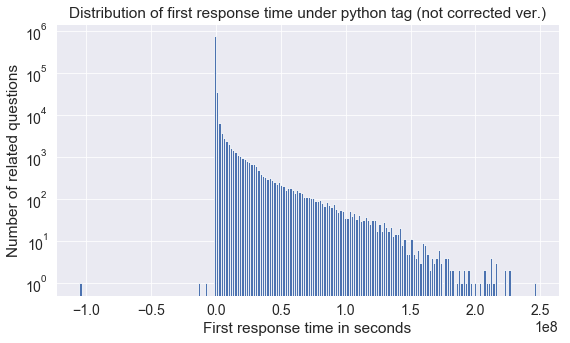

In [29]:
sns.set_context("paper", font_scale=1.6)
pd_python_time.date_diff.hist(bins=200, log=True, figsize=(9,5))
plt.xlabel('First response time in seconds')
plt.ylabel('Number of related questions')
plt.title('Distribution of first response time under python tag (not corrected ver.)')

Text(0.5, 1.0, 'Distribution of first response time under java tag (not corrected ver.)')

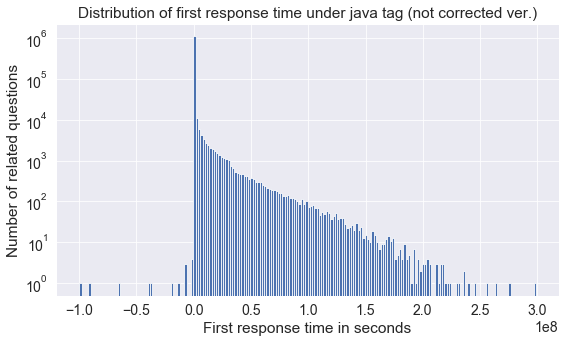

In [30]:
sns.set_context("paper", font_scale=1.6)
pd_java_time.date_diff.hist(bins=200, log=True, figsize=(9,5))
plt.xlabel('First response time in seconds')
plt.ylabel('Number of related questions')
plt.title('Distribution of first response time under java tag (not corrected ver.)')

We can notice that we have negative values for the response time, which does not make sense. We check the number of values which are negative or equal to zero for each tag.

In [31]:
print('Negative or zero values for python response time: {0} or {1:.2f} %'\
      .format(pd_python_time[pd_python_time.date_diff<=0].date_diff.count()\
        ,(pd_python_time[pd_python_time.date_diff<=0].date_diff.count()/pd_python_time.date_diff.count()*100)))

Negative or zero values for python response time: 2312 or 0.28 %


In [32]:
print('Negative or zero values for java response time: {0} or {1:.2f} %'\
      .format(pd_java_time[pd_java_time.date_diff<=0].date_diff.count()\
        ,(pd_java_time[pd_java_time.date_diff<=0].date_diff.count()/pd_java_time.date_diff.count()*100)))

Negative or zero values for java response time: 2252 or 0.19 %


From the results we get that 0.28 % from the response time of `python` tag and 0.19 % from the response time of `java` tag are negative or equal to zero. The reason could be that, stack flow dataset gives the final edition time but not the first publish time. 

Because an answer cannot exist before the question has been asked and since this data points occur in very small number compared to all answers, we consider them as mistakes and drop them. Below are the new histograms for the corrected values.

In [33]:
pd_python_time_pos = pd_python_time[pd_python_time.date_diff > 0]

In [34]:
pd_java_time_pos = pd_java_time[pd_java_time.date_diff > 0]

Text(0.5, 1.0, 'Distribution of first response time under python tag')

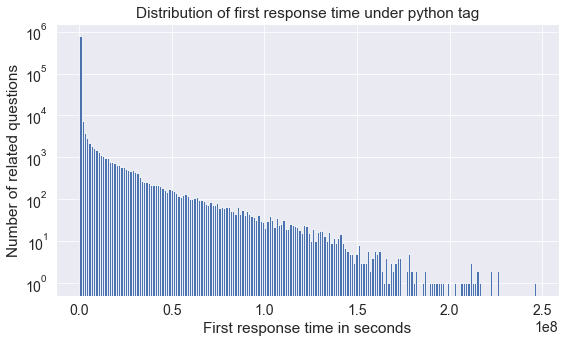

In [35]:
sns.set_context("paper", font_scale=1.6)
pd_python_time_pos.date_diff.hist(bins=200, log=True, figsize=(9,5))
plt.xlabel('First response time in seconds')
plt.ylabel('Number of related questions')
plt.title('Distribution of first response time under python tag')

Text(0.5, 1.0, 'Distribution of first response time under java tag')

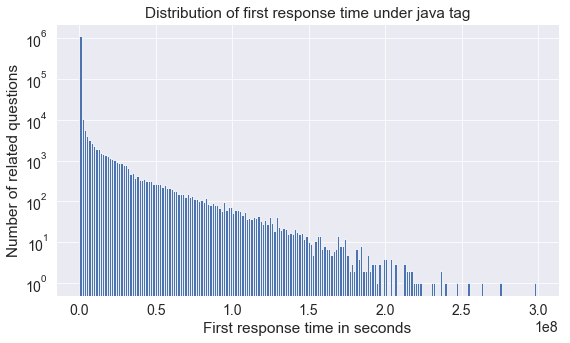

In [36]:
sns.set_context("paper", font_scale=1.6)
pd_java_time_pos.date_diff.hist(bins=200, log=True, figsize=(9,5))
plt.xlabel('First response time in seconds')
plt.ylabel('Number of related questions')
plt.title('Distribution of first response time under java tag')

We can easily notice that the histograms for both python and java are very similar, as we will demonstrate below with the statistics.

Now we can discuss the following distribution properties: mean, median, standard deviation for python and java response time.

In [37]:
pd_python_time_pos.describe()

,date_diff
count,"827,848"
mean,"983,717"
std,"6,908,426"
min,1
25%,425
50%,"1,357"
75%,"9,583"
max,"246,457,525"


In [38]:
print('Response time over one year: {0:.2f} %.\nResponse time over one month: {1:.2f} %'\
     .format(np.sum(pd_python_time_pos.date_diff>=31536000)/pd_python_time_pos.date_diff.count()*100,
             np.sum(pd_python_time_pos.date_diff>=2592000)/pd_python_time_pos.date_diff.count()*100))

Response time over one year: 0.90 %.
Response time over one month: 4.10 %


From the statistics results for `python` above first we can notice that the range of values is extremely big, namely from 1 second to 246,457,525 seconds or 7.8 years. Additionally, we can notice that the mean value of the response time is around 11.4 days (983,717 seconds) and is a consequence from a few data points which have very large values for the responce time due to the enormous time range. This is also the reason for the big standard deviation in the data of 6,908,426 seconds or 2.66 months. For instance, we have around 0.9 % from all of the data points with responce time over one year and 4.1 % from all of the data points with responce time over one month. This analysis only shows that for this dataset the mean is maybe not the best statistic to represent the data. On the other hand, if we take a look on the median with a value of approximately 22 minutes (1,357 seconds) or the 75% with value of 2.66 hours (9,583 seconds) we can conclude that these statistics are much more realistic for the given dataset.

In [39]:
pd_java_time_pos.describe()

,date_diff
count,"1,176,818"
mean,"998,876"
std,"7,133,064"
min,1
25%,396
50%,"1,224"
75%,"9,615"
max,"298,536,705"


In [40]:
print('Response time over one year: {0:.2f} %.\nResponse time over one month: {1:.2f} %'\
     .format(np.sum(pd_java_time_pos.date_diff>=31536000)/pd_java_time_pos.date_diff.count()*100,
             np.sum(pd_java_time_pos.date_diff>=2592000)/pd_java_time_pos.date_diff.count()*100))

Response time over one year: 0.90 %.
Response time over one month: 4.04 %


From the statistics results for `java` above first we can notice that the range of values is extremely big, from 1 second to 298,536,705 seconds or 9.5 years. Additionally, we can notice that the mean value of the response time is very similar to the responce time of python with a value of around 11.5 days (998,876 seconds) and the reason for this is the same one. The standard deviation is 7,133,064 seconds or 2.75 months. Here we have around 0.9 % from all of the data points with responce time over one year and 4.04 % from all of the data points with responce time over one month, which is almost the same as before. The conclusion for java is the same as in the python case due to the similarity in the dataset.

__Question3:__

In order to contradict or confirm the hypotesis for the response time for Python and Java, we decided to check with two statistcs, namely with the mean and median of the dataframes. We define a function `bootstrap_mean` which calculates the mean for a specific subset for a given number of iterations, and similarly the function `bootstrap_median` which calculates the median for a specific subset for a given number of iterations. Then we call the functions for python and java, and plot the 95% confidence intervals with box plots.

In [41]:
def bootstrap_mean(df, iternum=10, fraction=0.2):
    """
    Calculate the mean for a subset of the dataframe expressed through the fraction for 'iternum' number of iterations.
    
    Parameters:
        df: dataframe
        iternum: number of iterations, default=10
        fraction: fraction of the dataframe, default=0.2
        
    Return:
        List of the calculated means for the specified number of iterations for the subset
    """
    result = []
    for i in range(iternum):
        bootstrap_mean = df.sample(replace=True,frac=fraction).date_diff.mean()
        result.append(bootstrap_mean)
    return result

In [42]:
python_bootstrap_mean = bootstrap_mean(pd_python_time_pos, 50, 0.5)

In [43]:
java_bootstrap_mean = bootstrap_mean(pd_java_time_pos, 50, 0.5)

To check if the values for the mean from the bootstrap estimation are close to the real values of the mean for python and java tags, we calculate and present the apsolute and relative difference below:

In [44]:
print('Difference between python original mean and bootstrap mean: {0:.2f} or {1:.2f} %.\n'\
      'Difference between java original mean and bootstrap mean: {2:.2f} or {3:.2f} %.'\
     .format((np.mean(python_bootstrap_mean)-pd_python_time_pos.date_diff.mean()),
             (np.mean(python_bootstrap_mean)-pd_python_time_pos.date_diff.mean())/pd_python_time_pos.date_diff.mean()*100,
             (np.mean(java_bootstrap_mean)-pd_java_time_pos.date_diff.mean()),
             (np.mean(java_bootstrap_mean)-pd_java_time_pos.date_diff.mean())/pd_java_time_pos.date_diff.mean()*100))

Difference between python original mean and bootstrap mean: 1329.19 or 0.14 %.
Difference between java original mean and bootstrap mean: -1960.41 or -0.20 %.


And we can see that bootstrap method can estimate true mean very successfully.

In [45]:
results_mean = pd.DataFrame({'Python': python_bootstrap_mean,'Java':java_bootstrap_mean})

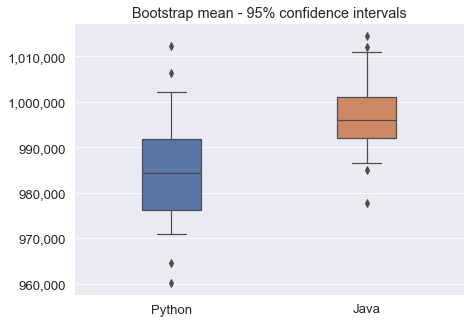

In [46]:
sns.set_context("paper", font_scale=1.5)
fig = plt.figure(figsize=(7,5))
fig = sns.boxplot(x=results_mean.columns, y=[results_mean['Python'],results_mean['Java']], whis=[2.5, 97.5], width=0.3)
plt.title('Bootstrap mean - 95% confidence intervals')
fig.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.show()


From the boxplot above, we can confirm that indeed Python has a lower response time compared to Java based on the mean as a statistic. The results were obtained by bootstrap on a subset using 50% of the original data from the dataframes and for 50 iterations.

Next, we will compare the results using the median as a statistic.

In [47]:
def bootstrap_median(df, iternum=10, fraction=0.2):
    """
    Calculate the median for a subset of the dataframe expressed through the fraction for 'iternum' number of iterations.
    
    Parameters:
        df: dataframe
        iternum: number of iterations, default=10
        fraction: fraction of the dataframe, default=0.2
        
    Return:
        List of the calculated medians for the specified number of iterations for the subset
    """
    result = []
    for i in range(iternum):
        bootstrap_median = df.sample(replace=True,frac=fraction).date_diff.median()
        result.append(bootstrap_median)
    return result

In [48]:
python_bootstrap_median = bootstrap_median(pd_python_time_pos, 50, 0.5)

In [49]:
java_bootstrap_median = bootstrap_median(pd_java_time_pos, 50, 0.5)

Similarly, to check if the values for the median from the bootstrap estimation are close to the real values of the median for python and java tags, we calculate and present the apsolute and relative difference below:

In [50]:
print('Difference between python original median and bootstrap median: {0:.2f} or {1:.2f} %.\n'\
      'Difference between java original median and bootstrap median: {2:.2f} or {3:.2f} %.'
     .format((np.mean(python_bootstrap_median)-pd_python_time_pos.date_diff.median()),
             (np.mean(python_bootstrap_median)-pd_python_time_pos.date_diff.median())/pd_python_time_pos.date_diff.median()*100,
             (np.mean(java_bootstrap_median)-pd_java_time_pos.date_diff.median()),
             (np.mean(java_bootstrap_median)-pd_java_time_pos.date_diff.median())/pd_java_time_pos.date_diff.median()*100))

Difference between python original median and bootstrap median: 1.23 or 0.09 %.
Difference between java original median and bootstrap median: 0.34 or 0.03 %.


And we can see that bootstrap method can estimate true median very successfully.

In [51]:
results_median = pd.DataFrame({'Python': python_bootstrap_median,'Java':java_bootstrap_median})

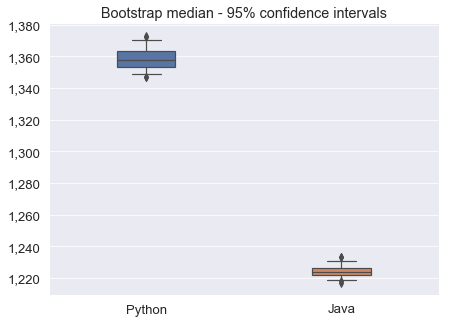

In [52]:
sns.set_context("paper", font_scale=1.5)
fig = plt.figure(figsize=(7,5))
fig = sns.boxplot(x=results_median.columns, y=[results_median['Python'],results_median['Java']], whis=[2.5, 97.5], width=0.3)
plt.title('Bootstrap median - 95% confidence intervals')
fig.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.show()


From the boxplot above, we have the opposite situation where Java has a lower response time compared to Python based on the median as a statistic. The results were obtained by bootstrap on a subset using 50% of the original data from the dataframes and for 50 iterations.

The different conclusion drew from mean and median can be explained by the large range of value, as mentioned in the last part of Task D, Q2. The response time of Java has larger value range than Python, and this will enlarge  its mean. To avoid influence from value range, quantile is a better choice. And as shown in the plot above, the median (50% quantile) distribution is much more compact and distinguishable for java and python than that of mean separatively.

So, here we reject the null hypothesis that python has lower response time than java but accept that java has lower response time on the contrary.

Thus, in following step, we decide to use `median` as the proper statistic to measure response time for other tags.

__Question4:__ Repeat the first analysis (D1) by using the proper statistic to measure the response time for the tags that appear at least 5000 times. Plot the distribution of the 10 tags with the fastest response time.

In this part, we first flat map all tags and group the result by tags, calculate counts and median response time for each tag. And then we sort the response time in order to find the 10 fastest answered tags and plot them in bar chart.

In [64]:
# in this part we flatten the dataframe by flatmapping tags in different questions 
# after faltmapping, each row in df_flat_tag is only one tag and its response time in certain question
tmp = time_diff.rdd.map(lambda line:[line.Tags.strip('<').strip('>').split('><'),line.date_diff])
flat_tag = tmp.flatMap(lambda line:[[tag,line[1]] for tag in line[0]])
df_flat_tag = flat_tag.toDF(['Tag','response time'])

In [65]:
# here we use udf function to calculate the median
def median(values_list):
    med = np.median(values_list)
    return float(med)
udf_median = func.udf(median, FloatType())

# we group the dataframe from former step by tags, and calculate the count and median separately for each tag
med_result = df_flat_tag.groupby('Tag').agg(count('*').alias('count'),
                                       udf_median(func.collect_list(col('response time'))).alias('median time')).cache()

In [75]:
# select the tag that are mentioned over 5000 times, and then sort the dataframe by median time
# then extract Tag and median time column to form a new dataframe for plotting
median_list = med_result.where(med_result['count']>5000).sort('median time')['Tag','median time']
pd_median = pd.DataFrame(median_list.head(10))
pd_median.columns = ['Tag','Response Time']

Text(0.5, 1.0, 'Bar chart for the 10 fastest responded tags (appeared at least 5000 times)')

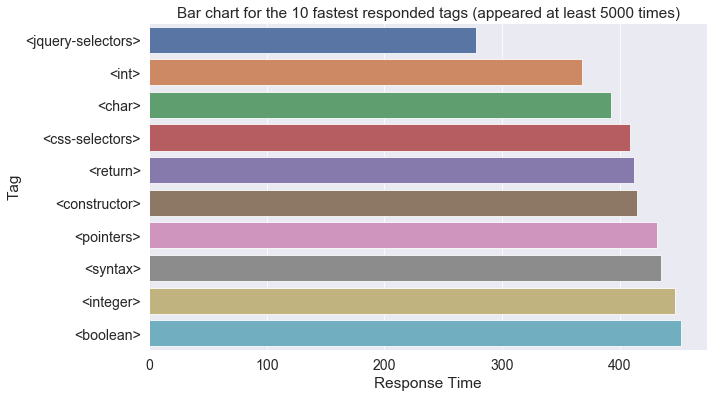

In [77]:
sns.set_context("paper", font_scale=1.6)
fig3 = plt.figure(figsize=(10,6))
fig3 = sns.barplot(pd_median['Response Time'], pd_median['Tag'])
fig3.set_title('Bar chart for the 10 fastest responded tags (appeared at least 5000 times)')

In [78]:
pd_median

,Tag,Response Time
718,<jquery-selectors>,278
776,<int>,368
675,<char>,393
657,<css-selectors>,409
789,<return>,412
427,<constructor>,415
147,<pointers>,432
421,<syntax>,435
746,<integer>,447
796,<boolean>,452


### Task E: What's up with PySpark?
The number of questions asked regarding a specific topic reflect the public’s interest on it. We are interested on the popularity of PySpark. Compute and plot the number of questions with the ```pyspark``` tag for 30-day time intervals. Do you notice any trend over time? Is there any correlation between time and number of questions?


At first, we get all the questions with `pyspark` tag and then sort them by time.

In [70]:
# Get questions with <pyspark> tag
question.registerTempTable("question_sql")
query_pyspark = """
select *
from question_sql
where Tags like '%<pyspark>%' 
"""

question_pyspark= spark.sql(query_pyspark)
question_pyspark.show(5)

+--------------------+--------+--------+----------+-----+--------------------+--------------------+---------+
|        CreationDate|      Id|ParentId|PostTypeId|Score|                Tags|               Title|ViewCount|
+--------------------+--------+--------+----------+-----+--------------------+--------------------+---------+
|2017-08-17 16:40:...|45740730|    null|         1|    0|<python><apache-s...|Balanced RDD part...|      123|
|2017-08-17 20:36:...|45744554|    null|         1|    0|<apache-spark><py...|Get row indices b...|     1703|
|2016-08-03 08:10:...|38737958|    null|         1|    0|<pyspark><apache-...|How to insert val...|     3589|
|2016-08-03 08:22:...|38738213|    null|         1|    1|<pyspark><pyspark...|Design a saturate...|      138|
|2016-08-03 12:06:...|38743194|    null|         1|    0|<scala><apache-sp...|Unable to find ja...|       45|
+--------------------+--------+--------+----------+-----+--------------------+--------------------+---------+
only showi

Then, we split the questions by month and count the frequncy. 
We use query to count the number of each month and order by time.

In [71]:
question_month = question_pyspark.select(date_format(question_pyspark.CreationDate, 'yyyy-MM-dd').alias('date'))
question_month.show(5)

+----------+
|      date|
+----------+
|2017-08-17|
|2017-08-17|
|2016-08-03|
|2016-08-03|
|2016-08-03|
+----------+
only showing top 5 rows



In order to group data by interval of 30 days, we set 2014-04-01 as the starting date which is the earliest date where pyspark tag appears in a question. Then, for each question it should be calculated the day difference with base time and divide the number by the time inverval of 30. Using this approach, we get group id showing what interval this question locate. Lastly, we group our data by groupid and count number of each category which means frequency in this interval.

In [72]:
# Use query to count the number of each month and order by time
question_month.registerTempTable("question_month_sql") #register in table
query_freq = """
select t.groupid, count(t.date) as freq
from
(
select q.date, floor(datediff(q.date, '2014-04-01')/30) as groupid
from question_month_sql as q
) as t
group by groupid
order by groupid
"""

result_freq = spark.sql(query_freq)
result_freq.show(5)

+-------+----+
|groupid|freq|
+-------+----+
|      0|   1|
|      4|   1|
|      6|   3|
|      7|   5|
|      8|   1|
+-------+----+
only showing top 5 rows



Use the data above to plot the frequency.

In [73]:
pyspark_freq = result_freq.toPandas()

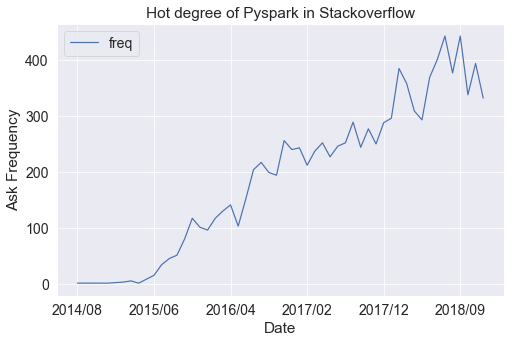

In [74]:
# Draw the plot with matplot
p = pyspark_freq.plot(x='groupid', y='freq', figsize=(8,5))
p.set_xlabel('Date')
p.set_ylabel('Ask Frequency')
p.set_xticklabels(['2014/04', '2014/08', '2015/06', '2016/04', '2017/02', '2017/12', '2018/09'])
p.set_title('Hot degree of Pyspark in Stackoverflow')
plt.show()

### Conclusion

We notice that from 2014.08 to 2018.09, more and more questions are posted on Stackoverflow. In particular, 2018.09 has a very small frequency, so we assume that people collect the data on early September and monthly data is not complete that time. The result shows that people are more likely to raise questions about `pyspark`, which indicates that pyspark has increasing importance in computer area and becomes a hot topic. 